In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rawankhaled20","key":"f5a17aecb67ca4675b425dadbe4ab60e"}'}

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets list

ref                                                         title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
iamsouravbanerjee/customer-shopping-trends-dataset          Customer Shopping Trends Dataset                   146KB  2023-10-05 06:45:37          13081        282  1.0              
asaniczka/top-spotify-songs-in-73-countries-daily-updated   Top Spotify Songs in 73 Countries (Daily Updated)    4MB  2023-10-29 23:37:09           1220         37  1.0              
nelgiriyewithana/billionaires-statistics-dataset            Billionaires Statistics Dataset (2023)             139KB  2023-09-29 13:39:28           6917        182  1.0              
zeesolver/consumer-behavior-and-shopping-habits-dataset     Consumer Behavior and Sho

In [ ]:
!kaggle datasets download -d krystalliu152/imbd-movie-reviewnpl

 97% 5.00M/5.14M [00:00<00:00, 49.2MB/s]
100% 5.14M/5.14M [00:00<00:00, 50.1MB/s]


In [ ]:
! unzip imbd-movie-reviewnpl.zip

Archive:  imbd-movie-reviewnpl.zip
  inflating: Review.csv              


In [ ]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# DATASET
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 10
BATCH_SIZE = 400

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [ ]:
df = pd.read_csv("Review.csv")

In [ ]:
print("Dataset size:", len(df))

Dataset size: 10000


In [ ]:
df.head(5)

,sentiment,review
0,Negative,I had no background knowledge of this movie be...
1,Negative,I am a huge Jane Austen fan and I ordered the ...
2,Negative,Nothing to say but Wow! Has anyone actually ha...
3,Negative,i like Jane Austin novels. I love Pride and Pr...
4,Negative,In this day and age of incredible special movi...


In [ ]:
decode_map = {"Negative": 0, "Positive": 1}

def decode_sentiment(label):
    return decode_map[label]

In [ ]:
%%time
df['sentiment'] = df['sentiment'].apply(decode_sentiment)

CPU times: user 8.76 ms, sys: 0 ns, total: 8.76 ms
Wall time: 10.4 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

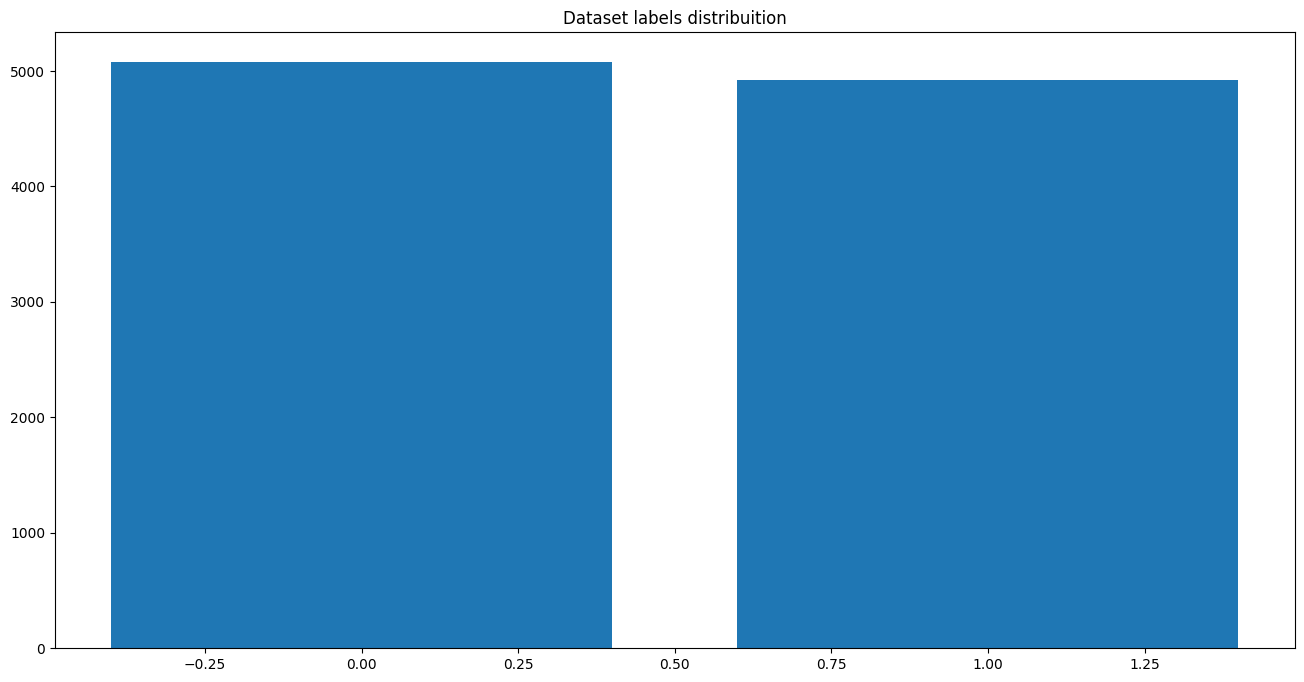

In [ ]:
target_cnt = Counter(df['sentiment'])

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [ ]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
%%time
df['review'] = df['review'].apply(lambda x: preprocess(x))

CPU times: user 5.52 s, sys: 8.36 ms, total: 5.53 s
Wall time: 5.58 s


In [ ]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 8000
TEST size: 2000


In [ ]:
%%time
# Check if 'review' column exists in df_train and contains valid data
if 'review' in df_train:
    documents = [str(item).split() for item in df_train['review']]

CPU times: user 87.9 ms, sys: 42.1 ms, total: 130 ms
Wall time: 130 ms


In [ ]:
w2v_model = gensim.models.Word2Vec(
    vector_size=W2V_SIZE,  # Instead of 'size', it's 'vector_size' in Gensim 4.x
    window=W2V_WINDOW,
    min_count=W2V_MIN_COUNT,
    workers=8
)

In [ ]:
w2v_model.build_vocab(documents)

In [ ]:
# Assuming 'w2v_model' is the Word2Vec model trained using Gensim

words = list(w2v_model.wv.key_to_index)  # Retrieve the vocabulary keys
vocab_size = len(words)  # Calculate the vocabulary size

print("Vocabulary size:", vocab_size)

Vocabulary size: 10150


In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 2min 28s, sys: 616 ms, total: 2min 28s
Wall time: 1min 25s


(26443962, 30631808)

In [ ]:
similar_words = w2v_model.wv.most_similar("love")

# Print the most similar words to "love"
for word in similar_words:
    print(word)

('asleep', 0.40244781970977783)
('flat', 0.318960964679718)
('category', 0.316630482673645)
('hate', 0.3044632077217102)
('romantic', 0.29972121119499207)
('romance', 0.29906603693962097)
('touching', 0.28983068466186523)
('loyalty', 0.2820403575897217)
('adore', 0.2809438109397888)
('phillip', 0.2679517865180969)


In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['review'])

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 46566
CPU times: user 789 ms, sys: 11 ms, total: 800 ms
Wall time: 806 ms


In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train['review']), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test['review']), maxlen=SEQUENCE_LENGTH)

CPU times: user 752 ms, sys: 23 ms, total: 775 ms
Wall time: 770 ms


In [ ]:
labels = df_train['sentiment'].unique().tolist()
labels.append(NEUTRAL)
labels

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train['sentiment'].tolist())

y_train = encoder.transform(df_train['sentiment'].tolist())
y_test = encoder.transform(df_test['sentiment'].tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (8000, 1)
y_test (2000, 1)


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (8000, 300)
y_train (8000, 1)

x_test (2000, 300)
y_test (2000, 1)


In [ ]:
y_train[:10]

array([[1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0]])

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(46566, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

# Assuming 'embedding_layer' is defined elsewhere in your code

model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))

# LSTM layer with increased units and dropout
model.add(LSTM(150, dropout=0.3, recurrent_dropout=0.3))

# Additional dense layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Another Dense layer before the final output layer
model.add(Dense(32, activation='relu'))

# Output layer
model.add(Dense(1, activation='sigmoid'))

for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Dense):  # Applying regularization to Dense layers
        layer.kernel_regularizer = regularizers.l2(0.01)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          13969800  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 150)               270600    
                                                                 
 dense (Dense)               (None, 64)                9664      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 3

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/10
18/18 [==============================] - ETA: 0s - loss: 0.6796 - accuracy: 0.5742

18/18 [==============================] - 135s 7s/step - loss: 0.6796 - accuracy: 0.5742 - val_loss: 0.6185 - val_accuracy: 0.6675 - lr: 0.0010
Epoch 2/10
18/18 [==============================] - ETA: 0s - loss: 0.5812 - accuracy: 0.6997

18/18 [==============================] - 127s 7s/step - loss: 0.5812 - accuracy: 0.6997 - val_loss: 0.6932 - val_accuracy: 0.7887 - lr: 0.0010
Epoch 3/10
18/18 [==============================] - ETA: 0s - loss: 0.4726 - accuracy: 0.7933

18/18 [==============================] - 131s 7s/step - loss: 0.4726 - accuracy: 0.7933 - val_loss: 0.4498 - val_accuracy: 0.8225 - lr: 0.0010
Epoch 4/10
18/18 [==============================] - ETA: 0s - loss: 0.4389 - accuracy: 0.8129

18/18 [==============================] - 131s 7s/step - loss: 0.4389 - accuracy: 0.8129 - val_loss: 0.4899 - val_accuracy: 0.8263 - lr: 0.0010
Epoch 5/10
18/18 [==============================] - ETA: 0s - loss: 0.4290 - accuracy: 0.8085

18/18 [==============================] - 128s 7s/step - loss: 0.4290 - accuracy: 0.8085 - val_loss: 0.4877 - val_accuracy: 0.8213 - lr: 0.0010
Epoch 6/10
18/18 [==============================] - ETA: 0s - loss: 0.4029 - accuracy: 0.8275

18/18 [==============================] - 121s 7s/step - loss: 0.4029 - accuracy: 0.8275 - val_loss: 0.5771 - val_accuracy: 0.8075 - lr: 0.0010
Epoch 7/10
18/18 [==============================] - ETA: 0s - loss: 0.3974 - accuracy: 0.8353

18/18 [==============================] - 123s 7s/step - loss: 0.3974 - accuracy: 0.8353 - val_loss: 0.4258 - val_accuracy: 0.8288 - lr: 0.0010
Epoch 8/10
18/18 [==============================] - ETA: 0s - loss: 0.3953 - accuracy: 0.8332

18/18 [==============================] - 128s 7s/step - loss: 0.3953 - accuracy: 0.8332 - val_loss: 0.4574 - val_accuracy: 0.8338 - lr: 0.0010
Epoch 9/10
18/18 [==============================] - ETA: 0s - loss: 0.3692 - accuracy: 0.8458

18/18 [==============================] - 124s 7s/step - loss: 0.3692 - accuracy: 0.8458 - val_loss: 0.4555 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 10/10
18/18 [==============================] - ETA: 0s - loss: 0.3698 - accuracy: 0.8443

18/18 [==============================] - 119s 7s/step - loss: 0.3698 - accuracy: 0.8443 - val_loss: 0.4421 - val_accuracy: 0.8313 - lr: 0.0010
CPU times: user 33min 34s, sys: 1min 56s, total: 35min 30s
Wall time: 21min 25s


In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

5/5 [==============================] - 9s 2s/step - loss: 0.5137 - accuracy: 0.8045

ACCURACY: 0.8044999837875366
LOSS: 0.5137017965316772
CPU times: user 13.1 s, sys: 1.22 s, total: 14.3 s
Wall time: 8.91 s


In [ ]:
def decode_sentiment(score, include_neutral=False):
    NEGATIVE = 'NEGATIVE'
    POSITIVE = 'POSITIVE'

    if include_neutral:
        if score < 0.5:
            return NEGATIVE
        elif score > 0.5:
            return POSITIVE
        else:
            return 'NEUTRAL'  # If the score is exactly 0.5, considering it as neutral
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [ ]:
predict("I love the music")

1/1 [==============================] - 0s 202ms/step


{'label': 'POSITIVE',
 'score': 0.9247063398361206,
 'elapsed_time': 0.26065850257873535}

In [ ]:
predict("I hate the rain")

1/1 [==============================] - 0s 200ms/step


{'label': 'POSITIVE',
 'score': 0.8327181935310364,
 'elapsed_time': 0.25303101539611816}

In [ ]:
predict("not good")

1/1 [==============================] - 0s 233ms/step


{'label': 'POSITIVE',
 'score': 0.8527939319610596,
 'elapsed_time': 0.3071002960205078}